In [1]:
import sys
from itertools import repeat
import data, data.gene_datasets
import sklearn, sklearn.model_selection, sklearn.metrics, sklearn.linear_model, sklearn.neural_network, sklearn.tree
import numpy as np
import matplotlib, matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import gene_inference, gene_inference.utils
from gene_inference.models import lr, mlp, decision_tree
from gene_inference.infer_genes import infer_gene, infer_all_genes, sample_neighbors


/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
tcgatissue = data.gene_datasets.TCGATissue(data_dir='./genomics/TCGA/')
class Object(object):
    pass

opt = Object()
opt.seed = 0
opt.nb_class = None
opt.nb_examples = None
opt.nb_nodes = None
opt.graph = "pathway"
opt.dataset = tcgatissue

tcgatissue.set_graph(opt)
g = nx.from_numpy_matrix(tcgatissue.adj)
mapping = dict(zip(range(0, len(tcgatissue.df.columns)), tcgatissue.df.columns))
g = nx.relabel_nodes(g, mapping)

Converting one-hot labels to integers
'Graph' object has no attribute 'labels'


In [3]:
def predict_gene_from_samples(gene, method, max_samples):
    full_results = pd.DataFrame([])
    first_degree_results = pd.DataFrame([])
    first_degree = set(g.neighbors(gene))
    first_degree.add(gene)
    first_degree_graph = g.subgraph(first_degree)

    for num_samples in range(10, max_samples, 10):
        full_results = full_results.append(infer_gene(method, tcgatissue.df[:1000], gene, g, num_samples, penalty=True)).reset_index(drop=True)
        full_results.loc[full_results.index[-1], 'samples'] = num_samples
        first_degree_results = first_degree_results.append(infer_gene(method, tcgatissue.df.loc[:1000, first_degree], gene, first_degree_graph, num_samples, penalty=True)).reset_index(drop=True)
        first_degree_results.loc[first_degree_results.index[-1], 'samples'] = num_samples
    return full_results, first_degree_results


In [ ]:
max_samples = 200
full_results_1, first_degree_results_1 = predict_gene_from_samples("RPL5", lr, 200)
print "1"
full_results_2, first_degree_results_2 = predict_gene_from_samples("RPL5", mlp, 200)
print "2"
full_results_3, first_degree_results_3 = predict_gene_from_samples("RPL5", decision_tree, 200)
print "3"

In [10]:
# cgn

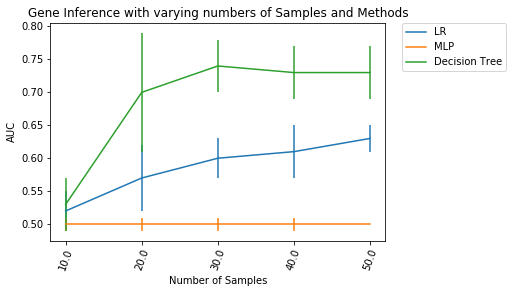

In [13]:
plt.figure()

line1 = plt.errorbar(full_results_1.index, full_results_1['auc'], xerr=0, yerr=full_results_1['std'])
line2 = plt.errorbar(full_results_2.index, full_results_2['auc'], xerr=0, yerr=full_results_2['std'])
line3 = plt.errorbar(full_results_3.index, full_results_3['auc'], xerr=0, yerr=full_results_3['std'])

width = 0.2
plt.xticks(list(full_results_1.iloc[::1, :].index), full_results_1.iloc[::1, :]['samples'], rotation=70)
plt.title("Gene Inference with varying numbers of Samples and Methods")
plt.ylabel("AUC")
plt.xlabel("Number of Samples")
plt.legend((line1[0], line2[0], line3[0]), ('LR', 'MLP', 'Decision Tree'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)